# 训练分类器

目前为止，我们以及看到了如何定义网络，计算损失，并更新网络的权重。

现在可能会想，

## 数据呢？

通常来说，当必须处理图像、文本、音频或视频数据时，可以使用python标准库将数据加载到numpy数组里。然后将这个数组转化成`torch.*Tensor`。

* 对于图片，有Pillow，OpenCV等包可以使用
* 对于音频，有scipy和librosa等包可以使用
* 对于文本，不管是原生python的或者是基于Cython的文本，可以使用NLTK和SpaCy

特别对于视觉方面，我们创建了一个包，名字叫`torchvision`，其中包含了针对Imagenet、CIFAR10、MNIST等常用数据集的数据加载器（data loaders），还有对图片数据变形的操作，即`torchvision.datasets`和`torch.utils.data.DataLoader`。

这提供了极大的便利，可以避免编写样板代码。

在这个教程中，我们将使用CIFAR10数据集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。在CIFAR-10里面的图片数据大小是3x32x32，即三通道彩色图，图片大小是32x32像素。

![](assets/cifar10.png)

## 训练一个图片分类器

我们将按顺序做以下步骤：

1. 通过`torchvision`加载CIFAR10里面的训练和测试数据集，并对数据进行标准化
2. 定义卷积神经网络
3. 定义损失函数
4. 利用训练数据训练网络
5. 利用测试数据测试网络

### 1.加载并标准化CIFAR10

使用`torchvision`加载CIFAR10超级简单。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


为了好玩，让我们展示一些训练数据的图片。

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x560 with 1 Axes>

 deer   dog  frog  bird


![](assets/sphx_glr_cifar10_tutorial_001.png)

### 2.定义卷积神经网络

将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像（替代原来定义的单通道图像）。

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3.定义损失函数和优化器

我们使用分类的交叉熵损失和随机梯度下降（使用momentum）。

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4.训练网络

事情开始变得有趣了。我们只需要遍历我们的数据迭代器，并且输入“喂”给网络和优化函数。

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.838
[1,  6000] loss: 1.678
[1,  8000] loss: 1.564
[1, 10000] loss: 1.485
[1, 12000] loss: 1.446
[2,  2000] loss: 1.394
[2,  4000] loss: 1.369
[2,  6000] loss: 1.338
[2,  8000] loss: 1.291
[2, 10000] loss: 1.262
[2, 12000] loss: 1.262
Finished Training


### 5.使用测试数据测试网络

我们已经在训练集上训练了2遍网络。但是我们需要检查网络是否学到了一些东西。

我们将通过预测神经网络输出的标签来检查这个问题，并和正确样本进行（ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们显示测试集中的图像来熟悉一下。

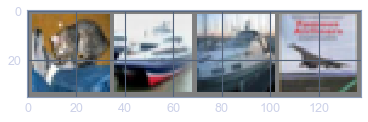

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

ok，现在让我们看看神经网络认为上面的例子是:

In [8]:
outputs = net(images)

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car plane plane


结果还不错。

让我们看看网络在整个数据集上表现的怎么样。

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


这比随机选取（即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 74 %
Accuracy of  bird : 30 %
Accuracy of   cat : 44 %
Accuracy of  deer : 46 %
Accuracy of   dog : 53 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 49 %
Accuracy of truck : 68 %


ok，接下来呢？

怎么在GPU上运行神经网络呢？

## 在GPU上训练

与将一个张量传递给GPU一样，可以这样将神经网络转移到GPU上。 

如果我们有cuda可用的话，让我们首先定义第一个设备为可见cuda设备：

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


本节的其余部分假设`device`是CUDA。

然后这些方法将递归遍历所有模块，并将它们的参数和缓冲区转换为CUDA张量：

In [13]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，我们不得不将输入和目标在每一步都送入GPU：

In [14]:
inputs, labels = inputs.to(device), labels.to(device)

为什么我们感受不到与CPU相比的巨大加速？因为我们的网络实在是太小了。

尝试一下：加宽你的网络（注意第一个`nn.Conv2d`的第二个参数和第二个`nn.Conv2d`的第一个参数要相同），看看能获得多少加速。

已实现的目标：

* 在更高层次上理解PyTorch的Tensor库和神经网络
* 训练一个小的神经网络做图片分类

## 在多GPU上训练

如果希望使用您所有GPU获得**更大的**加速，请查看[Optional: Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)。

## 接下来要做什么？

* [Train neural nets to play video games](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
* [Train a state-of-the-art ResNet network on imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
* [Train a face generator using Generative Adversarial Networks](https://github.com/pytorch/examples/tree/master/dcgan)
* [Train a word-level language model using Recurrent LSTM networks](https://github.com/pytorch/examples/tree/master/word_language_model)
* [More examples](https://github.com/pytorch/examples)
* [More tutorials](https://github.com/pytorch/tutorials)
* [Discuss PyTorch on the Forums](https://discuss.pytorch.org/)
* [Chat with other users on Slack](https://pytorch.slack.com/messages/beginner/)